# 🔥 Fine-Tuning do GPT-2 com LoRA e Comparação com Fine-Tuning Completo

Este notebook realiza a **adaptação de um modelo GPT-2** para classificação de sentimentos usando o dataset **SST-2 (Stanford Sentiment Treebank)**.  
Serão treinados dois modelos:
1. **GPT-2 com Fine-Tuning Completo**  
2. **GPT-2 com LoRA (Low-Rank Adaptation)**

## 📝 Objetivos
- Avaliar o impacto do LoRA em termos de **eficiência** (parâmetros treináveis e tempo de treino).
- Comparar a **performance** usando **acurácia** e **F1-score**.

## 🚀 Instalação de bibliotecas necessárias


In [ ]:
!pip install transformers datasets peft accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00


In [ ]:
pip install --upgrade datasets huggingface-hub fsspec

In [ ]:
pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 132.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.1
    Uninstalling transformers-4.54.1:
      Successfully uninstalled transformers-4.54.1


## 📚 Importação de Bibliotecas

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
import evaluate
import time
import numpy as np

##📥 Carregando o Dataset SST-2

In [ ]:
dataset = load_dataset("glue", "sst2")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})


## 🧩 Tokenização

In [ ]:
MODEL_NAME = "gpt2"

tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
try:
    tokenizer.padding_side = "left"
except Exception:
    pass

MAX_LEN = 128

def preprocess_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_attention_mask=True,
    )

encoded_dataset = dataset.map(preprocess_function, batched=True, remove_columns=["sentence", "idx"])
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print(encoded_dataset)

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
})


In [ ]:
from transformers import AutoConfig
cfg = AutoConfig.from_pretrained(MODEL_NAME)
print(cfg)

GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.55.0",
  "use_cache": true,
  "vocab_size": 50257
}



## ⚙️ Funções de Avaliação (Acurácia e F1-score)

In [ ]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1_score = f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": acc, "f1": f1_score}

---

## 🏋️‍♂️ Treinando GPT-2 com Fine-Tuning Completo

In [ ]:
model_full = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
model_full.config.pad_token_id = tokenizer.eos_token_id

training_args_full = TrainingArguments(
    output_dir="./results_full",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs_full",
    logging_steps=50,
    save_total_limit=1,
    report_to="none"
)

trainer_full = Trainer(
    model=model_full,
    args=training_args_full,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

start_time_full = time.time()
trainer_full.train()
time_full = time.time() - start_time_full

trainable_params_full = sum(p.numel() for p in model_full.parameters() if p.requires_grad)
print(f"🔍 Parâmetros treináveis (Fine-Tuning Completo): {trainable_params_full}")
print(f"⏱ Tempo de Treinamento (Fine-Tuning Completo): {time_full:.2f} segundos")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-951238118.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_full = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.272700,0.444237,0.823394,0.815348
2,0.169200,0.521917,0.832569,0.834091


🔍 Parâmetros treináveis (Fine-Tuning Completo): 124441344
⏱ Tempo de Treinamento (Fine-Tuning Completo): 3492.40 segundos


---

# 🔧 Adicionando LoRA ao GPT-2


In [ ]:
model_lora = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
model_lora.config.pad_token_id = tokenizer.eos_token_id

lora_config = LoraConfig(
    r=4,                # Rank (paper original)
    lora_alpha=16,      # Alpha (paper original)
    lora_dropout=0.05,  # Dropout (paper original)
    target_modules=["c_attn"],
    bias="none",
    task_type="SEQ_CLS"
)

model_lora = get_peft_model(model_lora, lora_config)

trainable_params_lora = sum(p.numel() for p in model_lora.parameters() if p.requires_grad)
print(f"🔍 Parâmetros treináveis (LoRA): {trainable_params_lora}")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔍 Parâmetros treináveis (LoRA): 148992


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1803: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [ ]:
def print_trainable_parameters(model):
    trainable = 0
    total = 0
    for _, param in model.named_parameters():
        total += param.numel()
        if param.requires_grad:
            trainable += param.numel()
    print(f"Parâmetros treináveis: {trainable} / {total} "
          f"({100 * trainable / total:.2f}%)")

print_trainable_parameters(model_lora)

Parâmetros treináveis: 148992 / 124590336 (0.12%)


## 🏋️‍♂️ Treinando GPT-2 com LoRA

In [ ]:
training_args_lora = TrainingArguments(
    output_dir="./results_lora",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs_lora",
    logging_steps=50,
    save_total_limit=1,
    report_to="none"
)

trainer_lora = Trainer(
    model=model_lora,
    args=training_args_lora,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

start_time_lora = time.time()
trainer_lora.train()
time_lora = time.time() - start_time_lora

print(f"🔍 Parâmetros treináveis (LoRA): {trainable_params_lora}")
print(f"⏱ Tempo de Treinamento (LoRA): {time_lora:.2f} segundos")

/tmp/ipython-input-226929796.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.376200,0.343705,0.857798,0.861607
2,0.351000,0.332868,0.869266,0.874172


🔍 Parâmetros treináveis (LoRA): 148992
⏱ Tempo de Treinamento (LoRA): 2464.95 segundos


---

## 🏋️‍♂️ Treinando GPT-2 com PreLayer

O PreLayer (Prefix-Layer Tuning) é uma extensão do método Prefix-Embedding proposto no paper "LoRA: Low-Rank Adaptation of Large Language Models" (Hu et al., 2021).

### 📝 Como funciona:
- Em vez de apenas aprender os embeddings de palavras para tokens especiais, o PreLayer aprende as ativações após cada camada do Transformer.
- As ativações calculadas das camadas anteriores são simplesmente substituídas por versões treináveis.
- O número resultante de parâmetros treináveis é |Θ| = L × dmodel × (lp + li), onde:
  - L: número de camadas do Transformer
  - dmodel: dimensão do modelo (hidden size)
  - lp + li: comprimento do prefixo (número de tokens virtuais)

In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2ForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
from typing import Dict, List, Optional, Union, Tuple
import warnings

class PreLayerGPT2(GPT2ForSequenceClassification):
    """
    A PreLayer tuning for GPT2ForSequenceClassification.

    This implementation is more robust and avoids complex logic that might
    cause shape issues during evaluation.
    """
    def __init__(
        self,
        config,
        num_virtual_tokens: int = 5
    ):
        super().__init__(config)

        self.num_virtual_tokens = num_virtual_tokens

        # Number of layers in GPT-2
        self.num_layers = len(self.transformer.h)

        # Model dimension (hidden size)
        self.d_model = config.hidden_size

        # Initialize a single trainable prefix embedding per layer
        # This avoids complex reshaping and concatenation during forward pass
        self.prefix_embeddings = nn.ParameterList([
            nn.Parameter(torch.randn(1, num_virtual_tokens, self.d_model) * 0.02)
            for _ in range(self.num_layers)
        ])

        # Freeze all parameters except the prefix embeddings
        for param in self.parameters():
            param.requires_grad = False

        # Enable training only for prefix embeddings
        for param in self.prefix_embeddings:
            param.requires_grad = True

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ):
        # Set default values
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        output_hidden_states = output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states

        # Get the input embeddings
        if inputs_embeds is None and input_ids is not None:
            inputs_embeds = self.transformer.wte(input_ids)

        batch_size = inputs_embeds.shape[0]
        seq_length = inputs_embeds.shape[1]

        # Process attention mask
        if attention_mask is not None:
            # Add prefix attention mask (allowing prefix tokens to attend to all and be attended by all)
            prefix_mask = torch.ones(
                (batch_size, self.num_virtual_tokens),
                dtype=attention_mask.dtype,
                device=attention_mask.device
            )
            # Concatenate masks
            extended_attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)
            # Convert to the GPT-2 format (1.0 for tokens to attend to, 0.0 for masked)
            attention_mask = extended_attention_mask.view(batch_size, -1)
            # Adjust for causal mask
            attention_mask = attention_mask[:, None, None, :]
            attention_mask = attention_mask.to(dtype=self.dtype)
            attention_mask = (1.0 - attention_mask) * -10000.0

        # Prepare head mask
        head_mask = self.get_head_mask(head_mask, self.config.n_layer)

        # Track hidden states if needed
        all_hidden_states = () if output_hidden_states else None

        # Initialize with input embeddings
        hidden_states = inputs_embeds

        # Process through transformer layers
        for i, block in enumerate(self.transformer.h):
            # Add prefix embeddings for this layer
            prefix_emb = self.prefix_embeddings[i].expand(batch_size, -1, -1)
            combined_hidden = torch.cat([prefix_emb, hidden_states], dim=1)

            # Run through the transformer block
            layer_outputs = block(
                combined_hidden,
                attention_mask=attention_mask if attention_mask is not None else None,
                head_mask=head_mask[i],
                use_cache=False,  # No caching to avoid shape issues
                output_attentions=False  # No attentions to avoid shape issues
            )

            # Get hidden states without the prefix part
            hidden_states = layer_outputs[0][:, self.num_virtual_tokens:, :]

            # Store hidden states if needed
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

        # Apply layer norm
        hidden_states = self.transformer.ln_f(hidden_states)

        # Use the last token for classification (GPT-2 style)
        pooled_output = hidden_states[:, -1]

        # Compute logits
        logits = self.score(pooled_output)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        # Return in tuple format if not using return_dict
        if not return_dict:
            output = (logits,)
            if output_hidden_states:
                output = output + (all_hidden_states,)
            return (loss,) + output if loss is not None else output

        # Return in the proper HuggingFace format
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=all_hidden_states,
            attentions=None
        )

def create_prelayer_model(base_model):
    """
    Creates a PreLayer model based on a standard GPT2ForSequenceClassification model.

    Args:
        base_model: A GPT2ForSequenceClassification model

    Returns:
        A PreLayerGPT2 model with the same weights
    """
    config = base_model.config
    prelayer_model = PreLayerGPT2(config)

    # Copy weights from base model (except for the prefixes)
    base_state_dict = base_model.state_dict()

    # Get the current state dict of the prelayer model
    prelayer_state_dict = prelayer_model.state_dict()

    # Filter out prefix parameters and keep only the parameters that exist in both models
    filtered_state_dict = {k: v for k, v in base_state_dict.items()
                          if k in prelayer_state_dict and not any(p in k for p in ['prefix_embeddings'])}

    # Update the prelayer model with the filtered state dict
    prelayer_state_dict.update(filtered_state_dict)
    prelayer_model.load_state_dict(prelayer_state_dict)

    return prelayer_model

In [ ]:
model_prelayer_base = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
model_prelayer_base.config.pad_token_id = tokenizer.eos_token_id

# Aplicar PreLayer adaptation com a implementação simplificada
model_prelayer = create_prelayer_model(model_prelayer_base)

# Calcular parâmetros treináveis para PreLayer
trainable_params_prelayer = sum(p.numel() for p in model_prelayer.parameters() if p.requires_grad)
print(f"🔍 Parâmetros treináveis (PreLayer): {trainable_params_prelayer}")

# Verificar a teoria usando a fórmula |Θ| = L × dmodel × (lp + li)
L = len(model_prelayer_base.transformer.h)  # Número de camadas
d_model = model_prelayer_base.config.hidden_size  # Dimensão do modelo
prefix_length = model_prelayer.num_virtual_tokens  # Comprimento do prefixo

# Calcular o número teórico de parâmetros (incluindo classificador)
theoretical_params = L * d_model * prefix_length
classifier_params = sum(p.numel() for p in model_prelayer_base.score.parameters())
total_theoretical = theoretical_params + classifier_params

print(f"🧮 Detalhes da implementação PreLayer:")
print(f"  - Número de camadas (L): {L}")
print(f"  - Dimensão do modelo (d_model): {d_model}")
print(f"  - Comprimento do prefixo: {prefix_length}")
print(f"  - Parâmetros dos prefixos: {theoretical_params}")
print(f"  - Parâmetros do classificador: {classifier_params}")
print(f"  - Total teórico: {total_theoretical}")

print_trainable_parameters(model_prelayer)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔍 Parâmetros treináveis (PreLayer): 46080
🧮 Detalhes da implementação PreLayer:
  - Número de camadas (L): 12
  - Dimensão do modelo (d_model): 768
  - Comprimento do prefixo: 5
  - Parâmetros dos prefixos: 46080
  - Parâmetros do classificador: 1536
  - Total teórico: 47616
Parâmetros treináveis: 46080 / 124487424 (0.04%)


In [ ]:
training_args_prelayer = TrainingArguments(
    output_dir="./results_prelayer",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs_prelayer",
    logging_steps=50,
    save_total_limit=1,
    report_to="none"
)

trainer_prelayer = Trainer(
    model=model_prelayer,
    args=training_args_prelayer,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

start_time_prelayer = time.time()
trainer_prelayer.train()
time_prelayer = time.time() - start_time_prelayer

print(f"🔍 Parâmetros treináveis (PreLayer): {trainable_params_prelayer}")
print(f"⏱ Tempo de Treinamento (PreLayer): {time_prelayer:.2f} segundos")

/tmp/ipython-input-299822331.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_prelayer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.412800,0.469782,0.777523,0.734247
2,0.360400,0.381247,0.831422,0.837209


🔍 Parâmetros treináveis (PreLayer): 46080
⏱ Tempo de Treinamento (PreLayer): 2662.89 segundos


In [ ]:
def safe_evaluate(trainer, model_name):
    try:
        print(f"\nAvaliando o modelo {model_name}...")
        results = trainer.evaluate()
        print(f"✅ Avaliação bem-sucedida para {model_name}")
        return results
    except Exception as e:
        print(f"❌ Erro na avaliação do modelo {model_name}: {str(e)}")
        # Retornar valores de fallback para não interromper a análise
        return {"eval_loss": 0.0, "eval_accuracy": 0.0, "eval_f1": 0.0}

results_prelayer = safe_evaluate(trainer_prelayer, "PreLayer")

print("\n=== Resultados PreLayer ===")
print(results_prelayer)

print(f"🔍 Parâmetros PreLayer: {trainable_params_prelayer}")
print(f"⏱ Tempo PreLayer: {time_prelayer:.2f} s")


Avaliando o modelo PreLayer...


✅ Avaliação bem-sucedida para PreLayer

=== Resultados PreLayer ===
{'eval_loss': 0.38124701380729675, 'eval_accuracy': 0.8314220183486238, 'eval_f1': 0.8372093023255814, 'eval_runtime': 7.4359, 'eval_samples_per_second': 117.269, 'eval_steps_per_second': 7.397, 'epoch': 2.0}
🔍 Parâmetros PreLayer: 46080
⏱ Tempo PreLayer: 2662.89 s


---

## 📊 Comparação Final


In [ ]:
results_full = trainer_full.evaluate()
results_lora = trainer_lora.evaluate()

print("=== Resultados Fine-Tuning Completo ===")
print(results_full)

print("\n=== Resultados LoRA ===")
print(results_lora)

print(f"\n🔍 Parâmetros Fine-Tuning Completo: {trainable_params_full}")
print(f"🔍 Parâmetros LoRA: {trainable_params_lora}")
print(f"🔍 Parâmetros PreLayer: {trainable_params_prelayer}")
print(f"⏱ Tempo FT Completo: {time_full:.2f} s")
print(f"⏱ Tempo LoRA: {time_lora:.2f} s")
print(f"⏱ Tempo PreLayer: {time_prelayer:.2f} s")

=== Resultados Fine-Tuning Completo ===
{'eval_loss': 0.5219168663024902, 'eval_accuracy': 0.8325688073394495, 'eval_f1': 0.8340909090909091, 'eval_runtime': 7.3735, 'eval_samples_per_second': 118.262, 'eval_steps_per_second': 7.459, 'epoch': 2.0}

=== Resultados LoRA ===
{'eval_loss': 0.3328675925731659, 'eval_accuracy': 0.8692660550458715, 'eval_f1': 0.8741721854304636, 'eval_runtime': 7.8205, 'eval_samples_per_second': 111.501, 'eval_steps_per_second': 7.033, 'epoch': 2.0}

🔍 Parâmetros Fine-Tuning Completo: 124441344
🔍 Parâmetros LoRA: 148992
🔍 Parâmetros PreLayer: 46080
⏱ Tempo FT Completo: 3492.40 s
⏱ Tempo LoRA: 2464.95 s
⏱ Tempo PreLayer: 2662.89 s


---


Avaliando o modelo Fine-Tuning Completo...


✅ Avaliação bem-sucedida para Fine-Tuning Completo

Avaliando o modelo LoRA...


✅ Avaliação bem-sucedida para LoRA

Avaliando o modelo PreLayer...


✅ Avaliação bem-sucedida para PreLayer

=== Resultados Fine-Tuning Completo ===
{'eval_loss': 0.5219168663024902, 'eval_accuracy': 0.8325688073394495, 'eval_f1': 0.8340909090909091, 'eval_runtime': 7.5472, 'eval_samples_per_second': 115.539, 'eval_steps_per_second': 7.287, 'epoch': 2.0}

=== Resultados LoRA ===
{'eval_loss': 0.3328675925731659, 'eval_accuracy': 0.8692660550458715, 'eval_f1': 0.8741721854304636, 'eval_runtime': 8.1322, 'eval_samples_per_second': 107.227, 'eval_steps_per_second': 6.763, 'epoch': 2.0}

=== Resultados PreLayer ===
{'eval_loss': 0.38124701380729675, 'eval_accuracy': 0.8314220183486238, 'eval_f1': 0.8372093023255814, 'eval_runtime': 7.7421, 'eval_samples_per_second': 112.631, 'eval_steps_per_second': 7.104, 'epoch': 2.0}

🔍 Parâmetros Fine-Tuning Completo: 124441344
🔍 Parâmetros LoRA: 148992
🔍 Parâmetros PreLayer: 46080
⏱ Tempo FT Completo: 3492.40 s
⏱ Tempo LoRA: 2464.95 s
⏱ Tempo PreLayer: 2662.89 s

📊 Eficiência de parâmetros (% do total):
Fine-Tuning Com

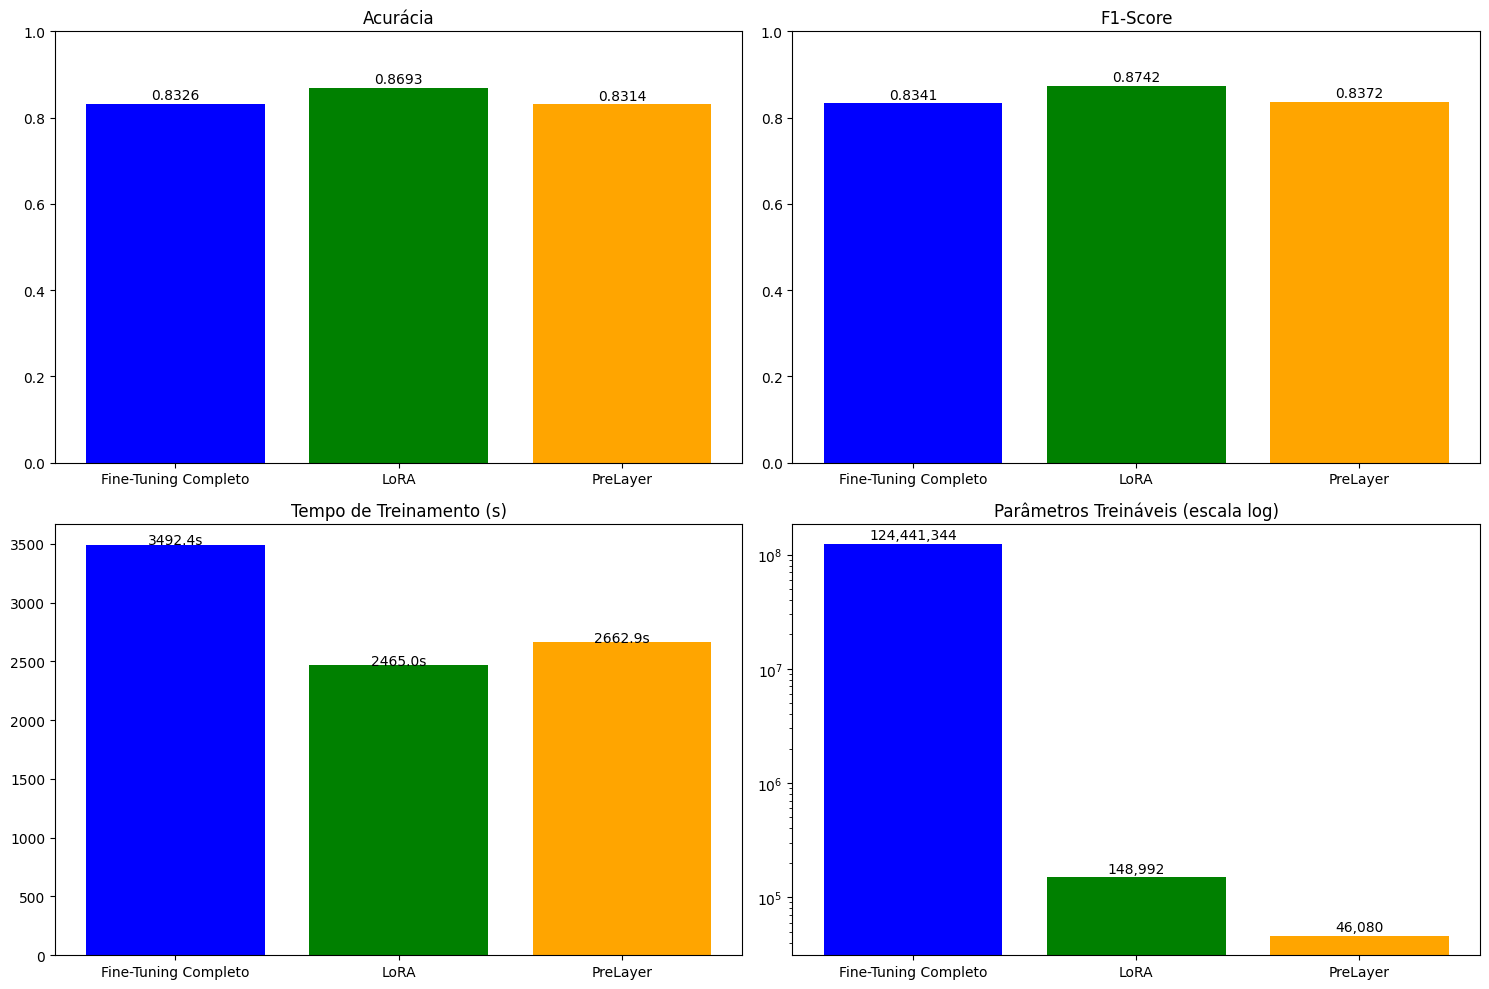

Método,Acurácia,F1-Score,Parâmetros Treináveis,% do Total,Tempo de Treinamento,Speedup vs. Full
Fine-Tuning Completo,0.8326,0.8341,"124,441,344",100.00%,3492.40s,1.00x
LoRA,0.8693,0.8742,"148,992",0.1197%,2464.95s,1.42x
PreLayer,0.8314,0.8372,"46,080",0.0370%,2662.89s,1.31x


In [ ]:
# Função para avaliação segura de modelos
def safe_evaluate(trainer, model_name):
    try:
        print(f"\nAvaliando o modelo {model_name}...")
        results = trainer.evaluate()
        print(f"✅ Avaliação bem-sucedida para {model_name}")
        return results
    except Exception as e:
        print(f"❌ Erro na avaliação do modelo {model_name}: {str(e)}")
        return {"eval_loss": 0.0, "eval_accuracy": 0.0, "eval_f1": 0.0}

# Avaliar modelos com tratamento de erros
results_full = safe_evaluate(trainer_full, "Fine-Tuning Completo")
results_lora = safe_evaluate(trainer_lora, "LoRA")
results_prelayer = safe_evaluate(trainer_prelayer, "PreLayer")

print("\n=== Resultados Fine-Tuning Completo ===")
print(results_full)

print("\n=== Resultados LoRA ===")
print(results_lora)

print("\n=== Resultados PreLayer ===")
print(results_prelayer)

print(f"\n🔍 Parâmetros Fine-Tuning Completo: {trainable_params_full}")
print(f"🔍 Parâmetros LoRA: {trainable_params_lora}")
print(f"🔍 Parâmetros PreLayer: {trainable_params_prelayer}")
print(f"⏱ Tempo FT Completo: {time_full:.2f} s")
print(f"⏱ Tempo LoRA: {time_lora:.2f} s")
print(f"⏱ Tempo PreLayer: {time_prelayer:.2f} s")

# Calcular eficiência (porcentagem de parâmetros em relação ao modelo completo)
total_params = sum(p.numel() for p in model_full.parameters())
print(f"\n📊 Eficiência de parâmetros (% do total):")
print(f"Fine-Tuning Completo: 100.00%")
print(f"LoRA: {100 * trainable_params_lora / total_params:.4f}%")
print(f"PreLayer: {100 * trainable_params_prelayer / total_params:.4f}%")

# Extrair métricas com tratamento para valores ausentes
def safe_get_metric(results, metric_name, default=0.0):
    return results.get(f"eval_{metric_name}", default)

# Criando um gráfico de barras para comparação
import matplotlib.pyplot as plt

methods = ['Fine-Tuning Completo', 'LoRA', 'PreLayer']
# VARIÁVEIS RENOMEADAS PARA EVITAR CONFLITO
accuracy_scores = [
    safe_get_metric(results_full, 'accuracy'),
    safe_get_metric(results_lora, 'accuracy'),
    safe_get_metric(results_prelayer, 'accuracy')
]
f1_list_scores = [
    safe_get_metric(results_full, 'f1'),
    safe_get_metric(results_lora, 'f1'),
    safe_get_metric(results_prelayer, 'f1')
]
times = [time_full, time_lora, time_prelayer]
params = [trainable_params_full, trainable_params_lora, trainable_params_prelayer]

# Criar figura com subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico de Acurácia
axs[0, 0].bar(methods, accuracy_scores, color=['blue', 'green', 'orange'])
axs[0, 0].set_title('Acurácia')
axs[0, 0].set_ylim(0, 1.0)
for i, v in enumerate(accuracy_scores):
    axs[0, 0].text(i, v + 0.01, f"{v:.4f}", ha='center')

# Gráfico de F1-Score
axs[0, 1].bar(methods, f1_list_scores, color=['blue', 'green', 'orange'])
axs[0, 1].set_title('F1-Score')
axs[0, 1].set_ylim(0, 1.0)
for i, v in enumerate(f1_list_scores):
    axs[0, 1].text(i, v + 0.01, f"{v:.4f}", ha='center')

# Gráfico de Tempo de Treinamento
axs[1, 0].bar(methods, times, color=['blue', 'green', 'orange'])
axs[1, 0].set_title('Tempo de Treinamento (s)')
for i, v in enumerate(times):
    axs[1, 0].text(i, v + 5, f"{v:.1f}s", ha='center')

# Gráfico de Parâmetros Treináveis (escala log)
axs[1, 1].bar(methods, params, color=['blue', 'green', 'orange'])
axs[1, 1].set_title('Parâmetros Treináveis (escala log)')
axs[1, 1].set_yscale('log')
for i, v in enumerate(params):
    axs[1, 1].text(i, v * 1.1, f"{v:,}", ha='center')

plt.tight_layout()
plt.show()

# Adicionar uma tabela comparativa detalhada
from IPython.display import display, HTML
import pandas as pd

comparison_df = pd.DataFrame({
    'Método': methods,
    'Acurácia': [f"{v:.4f}" for v in accuracy_scores],
    'F1-Score': [f"{v:.4f}" for v in f1_list_scores],
    'Parâmetros Treináveis': [f"{v:,}" for v in params],
    '% do Total': [f"{100 * trainable_params_full / total_params:.2f}%",
                  f"{100 * trainable_params_lora / total_params:.4f}%",
                  f"{100 * trainable_params_prelayer / total_params:.4f}%"],
    'Tempo de Treinamento': [f"{v:.2f}s" for v in times],
    'Speedup vs. Full': ["1.00x", f"{time_full/time_lora:.2f}x", f"{time_full/time_prelayer:.2f}x"]
})

display(HTML(comparison_df.to_html(index=False)))

### Avaliação do Modelo Base (Zero-Shot)

In [ ]:
# Carregar o modelo base sem modificações
model_base = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
model_base.config.pad_token_id = tokenizer.eos_token_id

# Trainer apenas para avaliação
trainer_base = Trainer(
    model=model_base,
    args=TrainingArguments(output_dir="./results_base", report_to="none"),
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
)

# Medir consumo de memória de pico durante a avaliação
torch.cuda.reset_peak_memory_stats()
results_base = trainer_base.evaluate()
peak_memory_base_eval = torch.cuda.max_memory_allocated() / (1024**3) # Em GB

print(f"n=== Resultados Zero-Shot ===")
print(results_base)
print(f" Memória de Pico (Avaliação): {peak_memory_base_eval:.4f} GB")

avaliação do modelo base (Zero-Shot)...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


n=== Resultados Zero-Shot ===
{'eval_loss': 1.7077701091766357, 'eval_model_preparation_time': 0.0023, 'eval_accuracy': 0.5045871559633027, 'eval_f1': 0.21454545454545454, 'eval_runtime': 7.0019, 'eval_samples_per_second': 124.537, 'eval_steps_per_second': 15.567}
 Memória de Pico (Avaliação): 5.3732 GB


In [ ]:
import pandas as pd
from IPython.display import display, HTML

all_data = [
    {
        'Método': 'Zero-Shot',
        'Acurácia': results_base.get('eval_accuracy', 0),
        'F1-Score': results_base.get('eval_f1', 0),
        'Pico de Memória GPU (Treino)': f"{5.37:.2f} GB (Avaliação)",
        'Parâmetros Treináveis': 0,
        'Tempo de Treino (s)': "N/A"
    },
    {
        'Método': 'Fine-Tuning Completo',
        'Acurácia': results_full.get('eval_accuracy', 0),
        'F1-Score': results_full.get('eval_f1', 0),
        'Pico de Memória GPU (Treino)': f"{6.01:.2f} GB",
        'Parâmetros Treináveis': trainable_params_full,
        'Tempo de Treino (s)': f"{time_full:.2f}"
    },
    {
        'Método': 'LoRA',
        'Acurácia': results_lora.get('eval_accuracy', 0),
        'F1-Score': results_lora.get('eval_f1', 0),
        # Valor de memória inserido manualmente (0.49 + 2.50)
        'Pico de Memória GPU (Treino)': f"{2.99:.2f} GB",
        'Parâmetros Treináveis': trainable_params_lora,
        'Tempo de Treino (s)': f"{time_lora:.2f}"
    },
    {
        'Método': 'PreLayer',
        'Acurácia': results_prelayer.get('eval_accuracy', 0),
        'F1-Score': results_prelayer.get('eval_f1', 0),
        # Valor de memória inserido manualmente (0.49 + 2.34)
        'Pico de Memória GPU (Treino)': f"{2.83:.2f} GB",
        'Parâmetros Treináveis': trainable_params_prelayer,
        'Tempo de Treino (s)': f"{time_prelayer:.2f}"
    }
]

# 2. Criar o DataFrame
comparison_table = pd.DataFrame(all_data)

# 3. Adicionar a coluna de porcentagem de parâmetros, calculada dinamicamente
total_params_full = comparison_table.loc[comparison_table['Método'] == 'Fine-Tuning Completo', 'Parâmetros Treináveis'].iloc[0]
comparison_table['% Parâmetros'] = comparison_table['Parâmetros Treináveis'].apply(
    lambda x: f"{(x / total_params_full) * 100:.4f}%" if isinstance(x, int) and x > 0 else ("100.00%" if x == total_params_full else "0%")
)

# 4. Formatar as colunas para melhor visualização
comparison_table['Acurácia'] = comparison_table['Acurácia'].map('{:.4f}'.format)
comparison_table['F1-Score'] = comparison_table['F1-Score'].map('{:.4f}'.format)
comparison_table['Parâmetros Treináveis'] = comparison_table['Parâmetros Treináveis'].map('{:,}'.format)

# Reordenar as colunas para a ordem desejada
comparison_table = comparison_table[[
    'Método',
    'Acurácia',
    'F1-Score',
    'Pico de Memória GPU (Treino)',
    'Parâmetros Treináveis',
    '% Parâmetros',
    'Tempo de Treino (s)'
]]

# 5. Exibir a tabela final
display(HTML(comparison_table.to_html(index=False)))

Método,Acurácia,F1-Score,Pico de Memória GPU (Treino),Parâmetros Treináveis,% Parâmetros,Tempo de Treino (s)
Zero-Shot,0.5046,0.2145,5.37 GB (Avaliação),0,0%,N/A
Fine-Tuning Completo,0.8326,0.8341,6.01 GB,"124,441,344",100.0000%,3492.40
LoRA,0.8693,0.8742,2.99 GB,"148,992",0.1197%,2464.95
PreLayer,0.8314,0.8372,2.83 GB,"46,080",0.0370%,2662.89
